# <h1 style='background:#CCCCCC; border:0; color:black'><center><span style="color: royalblue;"><span style="color: royalblue;">Intro</span></span></center></h1> 



<table>
    <tr>
        <td><img src="https://i.ibb.co/B394D0t/12.png" width="100%" height="100%"></td>
        <td><img src="https://i.ibb.co/5xV8MZj/40.png" width="100%" height="100%"></td>
        <td><img src="https://i.ibb.co/bFgXc43/19.png" width="100%" height="100%"></td>
    </tr>
</table>
The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centered and occupies about the same amount of space in each image. The task is to categorize each face based on the emotion shown in the facial expression in to one of seven categories:

| categorie  | emotion  |
|:---:|:---|
| 0  | Angry  |
| 1  |  Disgust |
| 2  |  Fear |
| 3  |  Happy |
| 4  |  Sad |
| 5  |  Surprise |
| 6  | Neutral |

# <h1 style='background:#CCCCCC; border:0; color:black'><center><span style="color: royalblue;">Libraries</span></center></h1> 
We load some standard libraries and packages of sklearn and keras.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

from sklearn.metrics import classification_report
import seaborn as sns
import joblib
import cv2
import tensorflow as tf

from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras import models
from keras.api.utils import to_categorical
from keras.api.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras.api.callbacks import ModelCheckpoint,EarlyStopping
import datetime
from keras import regularizers

# <h1 style='background:#CCCCCC; border:0; color:black'><center><span style="color: royalblue;"><span style="color: royalblue;">Load Data</span></span></center></h1> 
Load the image data with labels.

In [2]:
data = pd.read_csv('icml_face_data.csv')

# <h1 style='background:#CCCCCC; border:0; color:black'><center><span style="color: royalblue;"><span style="color: royalblue;">Exploratory Data Analysis</span></span></center></h1> 


## ICML Face Data
We will begin EDA by displaying the icml_face_data's shape and information

In [3]:
# displaying shape
print(f"ICML Face DataFrame Shape: {data.shape} \n ")

# displaying info
data.info()

ICML Face DataFrame Shape: (35887, 3) 
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1    Usage   35887 non-null  object
 2    pixels  35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


Now, we will look at the first 5 rows of the dataframe

In [4]:
data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


The "emotion" column represents the classes of facial expressions, while "Usage" denotes the different purposes of each image. The "pixels" column stores a string of pixels for each image. Now, let's look at the unique values in "emotion" and "Usage".

(Note: We will check the unique values of "pixels" later once we have it in the correct format).

In [5]:
# looking at unique values in each column
print(f"Unique Values in Emotion Column: {data['emotion'].unique()}")
print(f"Unique Values in Usage Column: {data[' Usage'].unique()}")

Unique Values in Emotion Column: [0 2 4 6 3 5 1]
Unique Values in Usage Column: ['Training' 'PublicTest' 'PrivateTest']


We have 7 emotion classes and 3 usage types. For now, we only want the "Training" rows to train the model. We will use the "PublicTest" and "PrivateTest" rows later to evaluate our model.

## Duplicates

We will drop duplicate images from the dataset to remove redundant information.

In [6]:
# dropping duplicate images
data = data.drop_duplicates(subset=' pixels')

# displaying rows
print(f"New data Shape: {data.shape}")

New data Shape: (34034, 3)


## Image Quality

We'll assess image quality by checking for meaningful content. If an image only contains one unique pixel, then we can infer that the image is a solid color and will not have any useful information for classifying emotions.

In [7]:
# splitting each string of pixel values and converting to array
pixels = data[' pixels'].apply(lambda x: np.fromstring(x, dtype=int, sep=' '))

# creating function to find images with only 1 unique pixel value -- if it's only 1 unique pixel value then the image is just one color
def same_pixel_value(row):
    return np.unique(row).size == 1

# retrieving rows
same_pixel_mask = pixels.apply(same_pixel_value)
same_pixel_true_indices = same_pixel_mask[same_pixel_mask==True].index
num_of_images = len(same_pixel_true_indices)

# displaying number of images
print(f"Number of Images with Only One Color: {num_of_images}")

Number of Images with Only One Color: 1


Let's drop the rows with only one color.

In [8]:
# dropping images with only one color
data = data.drop(same_pixel_true_indices)

# displaying new train shape
print(f"New data Shape: {data.shape}")

New data Shape: (34033, 3)


## Target Distribution

Let's check the distribution of the data.

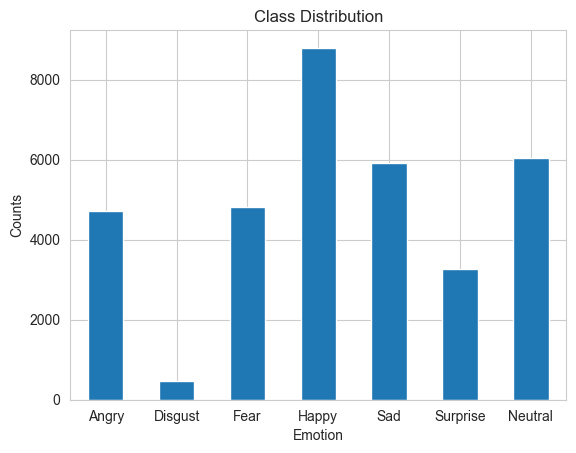

In [9]:
# storing emotion labels
label_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# calculating target distribution
td = data["emotion"].value_counts().sort_index()

# plotting
td.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Emotion')
plt.ylabel('Counts')
plt.xticks(ticks=range(len(label_names)), labels=label_names, rotation=0)
plt.show()

# <h1 style='background:#CCCCCC; border:0; color:black'><center><span style="color: royalblue;"><span style="color: royalblue;">Functions</span></span></center></h1> 
We define some helper functions for preparing and ploting the data.

The " pixels" column contains pixel values in string format. We'll create a function to convert these strings into image arrays for each row in the train dataframe. Additionally, we will create a label array from the "emotion" column. Ultimately, the purpose of this function is to format the train data into arrays so that it can be used in later steps.

In [10]:
def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels and pixel data
        output: image and label array """
    
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = data['emotion'].to_numpy()
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

def plot_examples(label=0):
    fig, axs = plt.subplots(1, 5, figsize=(25, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(5):
        idx = data[data['emotion']==label].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        
def plot_all_emotions():
    fig, axs = plt.subplots(1, 7, figsize=(30, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(7):
        idx = data[data['emotion']==i].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        
def plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, image_number):
    """ Function to plot the image and compare the prediction results with the label """
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    
    bar_label = emotions.values()
    
    axs[0].imshow(test_image_array[image_number], 'gray')
    axs[0].set_title(emotions[test_image_label[image_number]])
    
    axs[1].bar(bar_label, pred_test_labels[image_number], color='orange', alpha=0.7)
    axs[1].grid()
    
    plt.show()
    
def plot_compare_distributions(array1, array2, title1='', title2=''):
    df_array1 = pd.DataFrame()
    df_array2 = pd.DataFrame()
    df_array1['emotion'] = array1.argmax(axis=1)
    df_array2['emotion'] = array2.argmax(axis=1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    x = emotions.values()
    
    y = df_array1['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[0].bar(x, y.sort_index(), color='orange')
    axs[0].set_title(title1)
    axs[0].grid()
    
    y = df_array2['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[1].bar(x, y.sort_index())
    axs[1].set_title(title2)
    axs[1].grid()
    
    plt.show()

## Cropping Out Environment

While some of the images have a close view of the face, some may not. We will use [Haar Cascade](https://pyimagesearch.com/2021/04/12/opencv-haar-cascades/) to detect faces and crop out the surrounding environment. Afterwards, we will resize the images.

In [11]:
# loading haarcascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

# creating function to detect faces and crop out surroundings
def img_crop(image_dataset):

    #initializing empty variable to store cropped images
    new_images = []
    error_images = []

    # looping through each image in dataset
    for img in image_dataset:
        try:
            # detecting face
            face_detected = face_cascade.detectMultiScale(img.astype('uint8'))
            # checking if exactly 1 face is detected
            if len(face_detected) == 1:
                (x, y, w, h) = face_detected[0]
                # cropping image around detected face
                img_cropped = img[y + 1: y + h, x + 1 : x + w]
                # reshaping image to 48 x 48
                img_reshaped = cv2.resize(img_cropped, (48, 48))
                # appending reshaped images to new_images
                new_images.append(img_reshaped)
            else:
                # if no face detected or multiple faces detected, then keep the original image
                new_images.append(img)
        except Exception as e:
            new_images.append(img)

    # converting list to array
    new_images = np.array(new_images)

    return new_images

# <h1 style='background:#CCCCCC; border:0; color:black'><center><span style="color: royalblue;"><span style="color: royalblue;">Overview</span></span></center></h1> 

In [12]:
data[' Usage'].value_counts()

 Usage
Training       27472
PublicTest      3293
PrivateTest     3268
Name: count, dtype: int64

# <h1 style='background:#CCCCCC; border:0; color:black'><center><span style="color: royalblue;"><span style="color: royalblue;">Prepare Data</span></span></center></h1> 

In [13]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

Define training, validation and test data:

In [14]:
train_image_array, train_image_label = prepare_data(data[data[' Usage']=='Training'])
val_image_array, val_image_label = prepare_data(data[data[' Usage']=='PrivateTest'])
test_image_array, test_image_label = prepare_data(data[data[' Usage']=='PublicTest'])

Cropping out the environment in the train_images

In [15]:
train_image_array = img_crop(train_image_array)
val_image_array = img_crop(val_image_array)
test_image_array = img_crop(test_image_array)

## Data Augmentation

We will use data augmentation to improve the robustness of the model. Since the Happy class is the majority and presumably has a variety of images, we will only apply data augmentation to the other classes.

In [16]:
# creating arrays that only contain minority classes -- so everything excluding Happy(=3)
train_images_filtered = train_image_array[train_image_label != 3]
train_labels_filtered = train_image_label[train_image_label != 3]

# creating data generator for data augmentation -- only horizontal flip
datagen = ImageDataGenerator(horizontal_flip=True)

# adding additional dimension (color) to train_images_filtered since it is required for the input shape to be 4D
train_images_filtered = np.expand_dims(train_images_filtered, axis=-1)

# augmenting the images
datagen.fit(train_images_filtered)
augmented_images, augmented_labels = next(datagen.flow(train_images_filtered, train_labels_filtered, batch_size=len(train_images_filtered), shuffle=False))

# reshaping augmented_images back to 3 dimensions so it can be concatenated to back into the train_images
augmented_images = np.squeeze(augmented_images, axis=-1)

# adding augmented images to dataset
train_image_array = np.concatenate((train_image_array, augmented_images), axis=0)
train_image_label = np.concatenate((train_image_label, augmented_labels), axis=0)

# printing shape of new train_images and train_labels
print("New Shape of Train Images:", train_image_array.shape)
print("New Shape of Train Labels:", train_image_label.shape)

New Shape of Train Images: (47858, 48, 48)
New Shape of Train Labels: (47858,)


Let's take a look at the new distribution

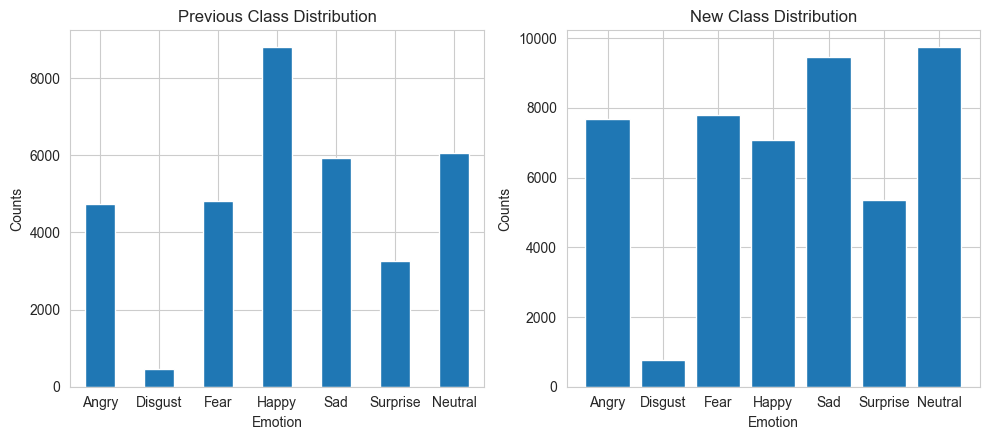

In [17]:
# retrieving new target distribution
unique_classes, class_counts = np.unique(train_image_label, return_counts=True)

# setting plot size
plt.figure(figsize=(10, 4.5))

# plotting previous distribution
plt.subplot(1, 2, 1)
td.plot(kind='bar')
plt.title('Previous Class Distribution')
plt.xlabel('Emotion')
plt.ylabel('Counts')
plt.xticks(ticks=range(len(label_names)), labels=label_names, rotation=0)

# plotting new distribution
plt.subplot(1, 2, 2)
plt.bar(unique_classes, class_counts)
plt.title('New Class Distribution')
plt.xlabel('Emotion')
plt.ylabel('Counts')
plt.xticks(ticks=range(len(label_names)), labels=label_names, rotation=0)

# adjusting layout
plt.tight_layout()

# displaying plots
plt.show()

Reshape and scale the images:

In [18]:
train_images = train_image_array.reshape((train_image_array.shape[0], 48, 48, 1))
train_images = train_images.astype('float32')/255
val_images = val_image_array.reshape((val_image_array.shape[0], 48, 48, 1))
val_images = val_images.astype('float32')/255
test_images = test_image_array.reshape((test_image_array.shape[0], 48, 48, 1))
test_images = test_images.astype('float32')/255

Encoding of the target value:

In [19]:
train_labels = to_categorical(train_image_label)
val_labels = to_categorical(val_image_label)
test_labels = to_categorical(test_image_label)

# <h1 style='background:#CCCCCC; border:0; color:black'><center><span style="color: royalblue;"><span style="color: royalblue;">Some Examples</span></span></center></h1> 

## All Emotions

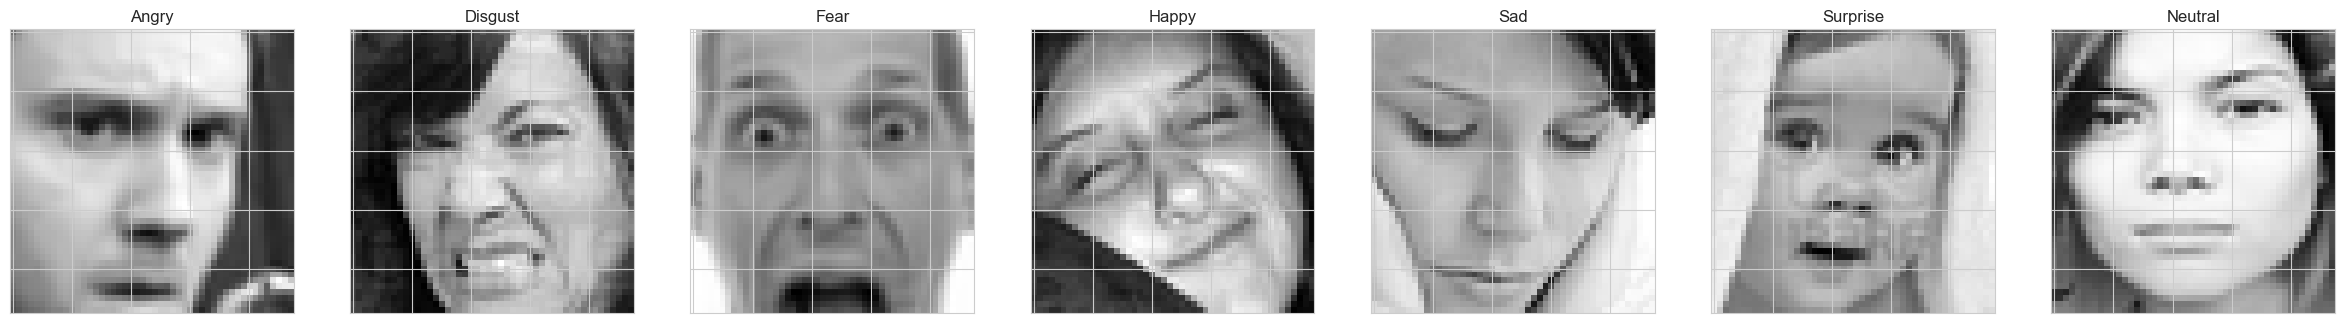

In [20]:
plot_all_emotions()

## Angry

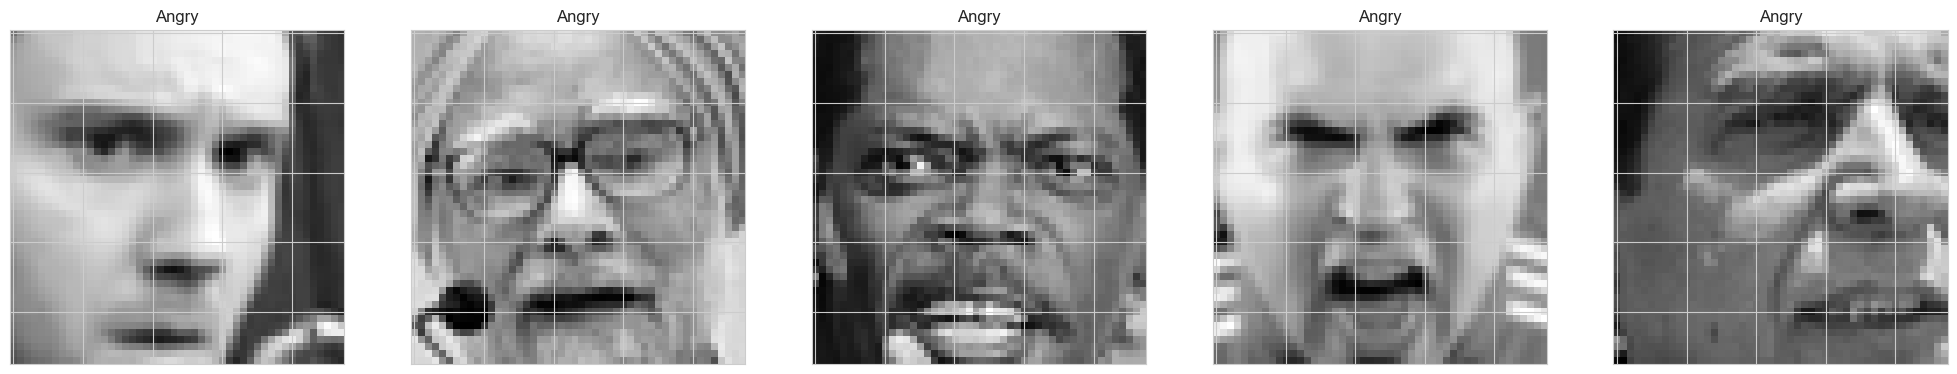

In [21]:
plot_examples(label=0)

## Disgust

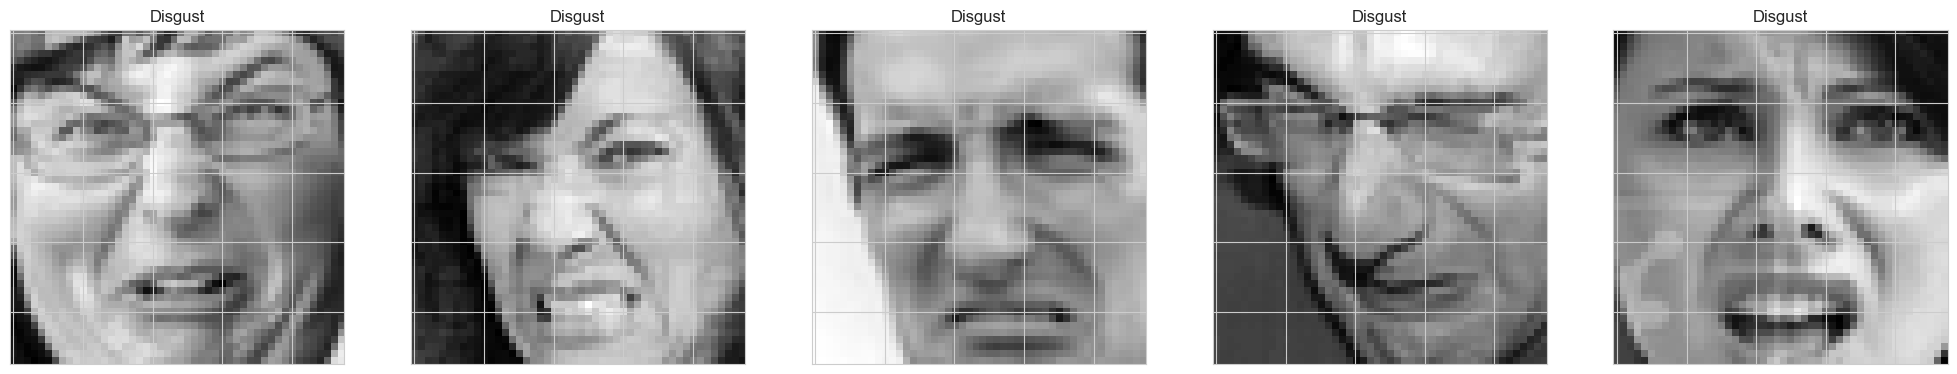

In [22]:
plot_examples(label=1)

## Fear

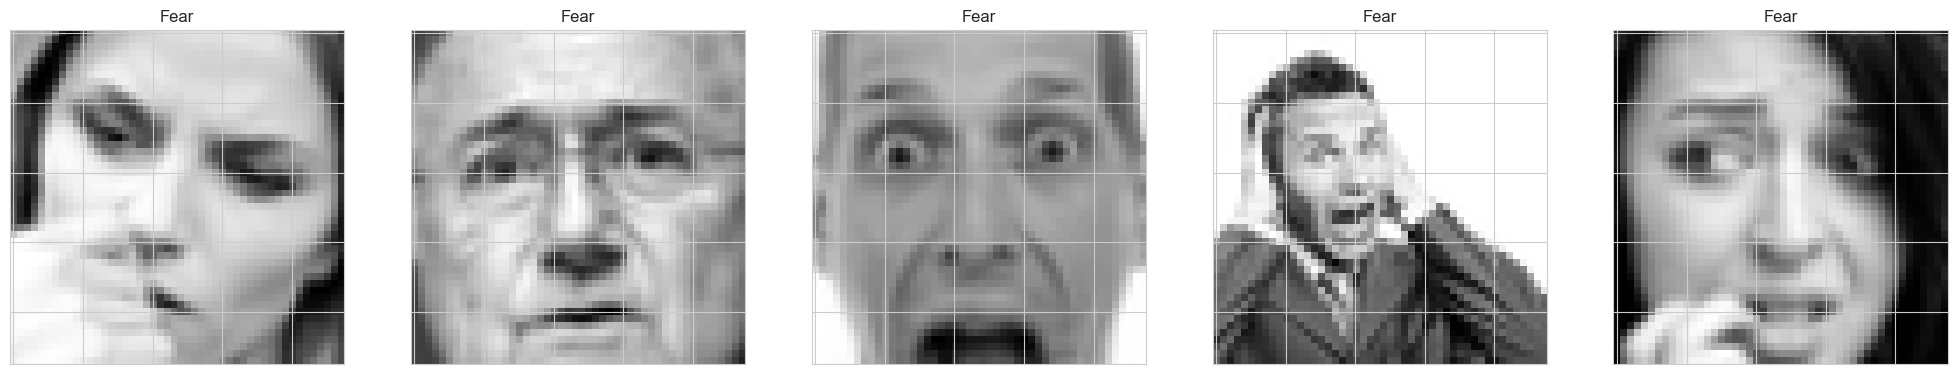

In [23]:
plot_examples(label=2)

## Happy

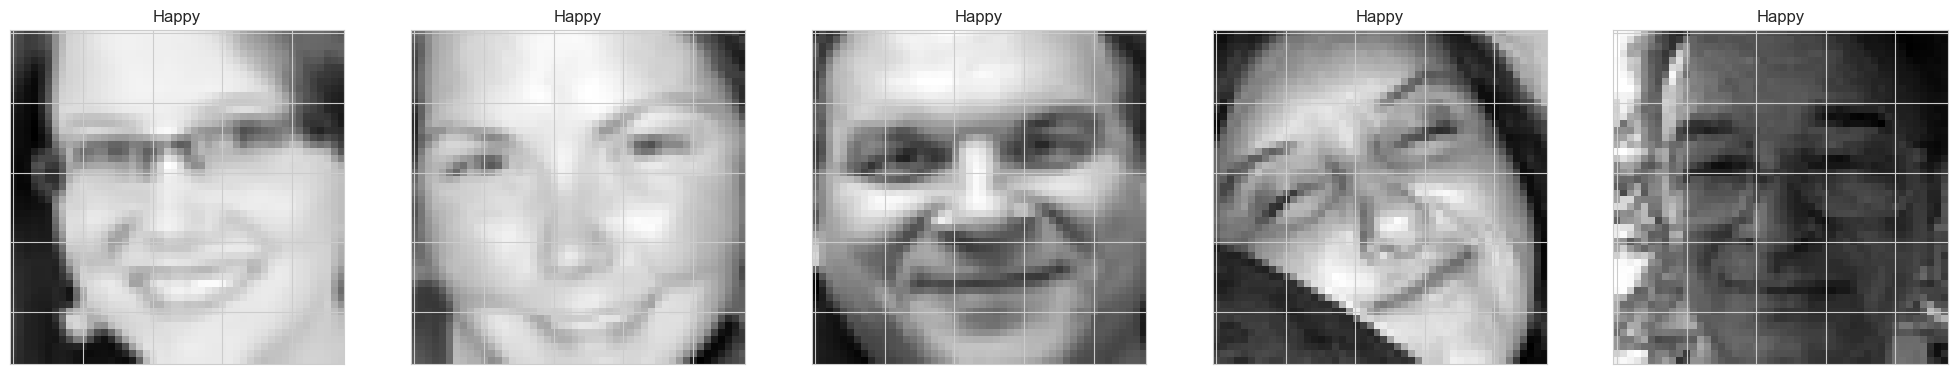

In [24]:
plot_examples(label=3)


## Sad

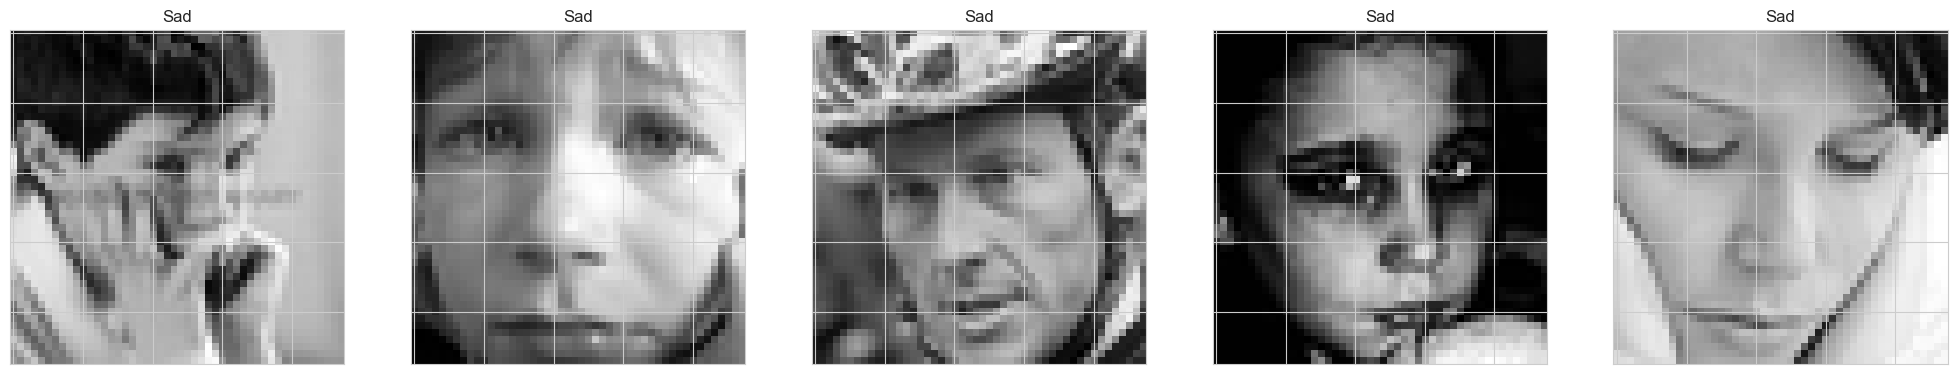

In [25]:
plot_examples(label=4)

## Surprise

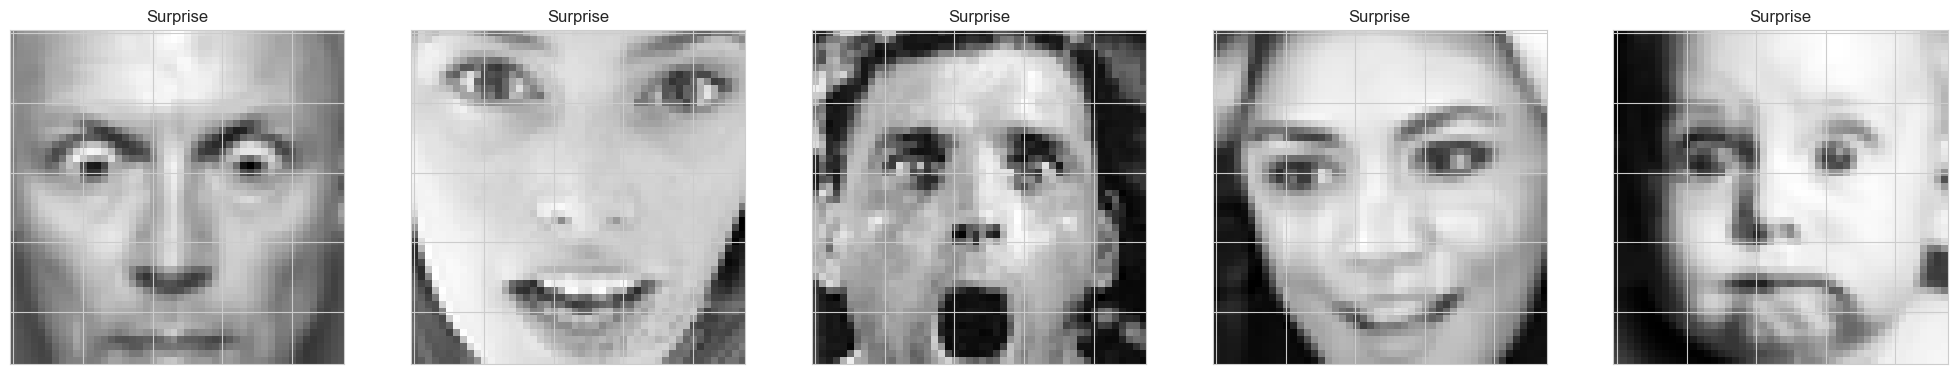

In [26]:
plot_examples(label=5)

## Neutral

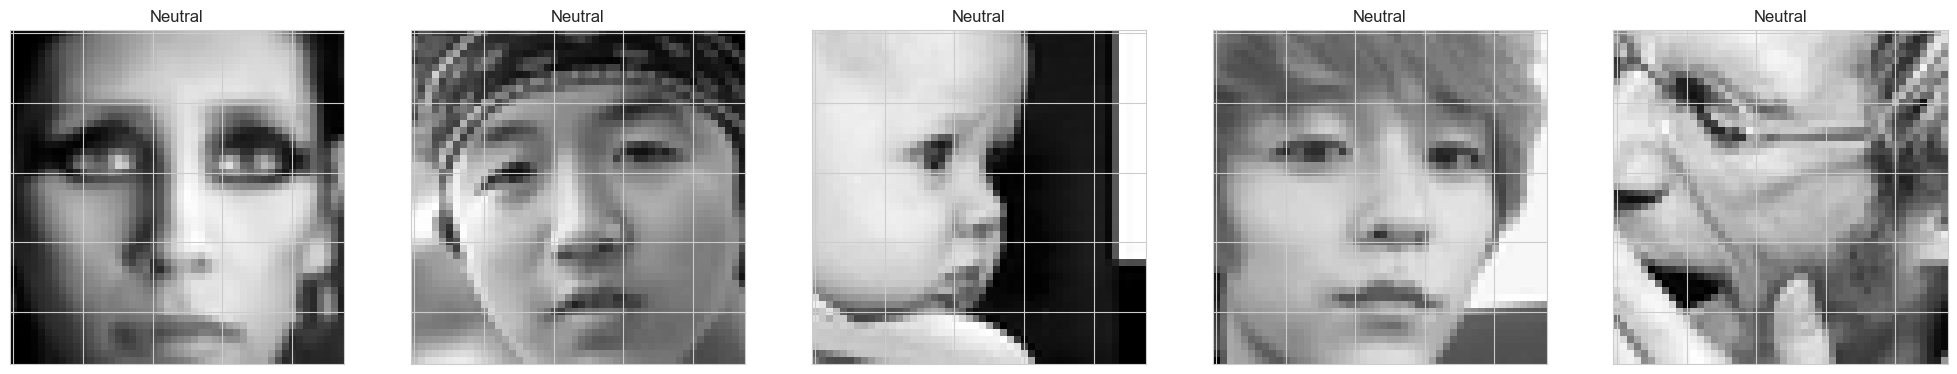

In [27]:
plot_examples(label=6)

# <h1 style='background:#CCCCCC; border:0; color:black'><center><span style="color: royalblue;"><span style="color: royalblue;">Class Weights</span></span></center></h1> 
Calculate the class weights of the label distribution:

In [28]:
class_weight = dict(zip(range(0, 7), (((data[data[' Usage']=='Training']['emotion'].value_counts()).sort_index())/len(data[data[' Usage']=='Training']['emotion'])).tolist()))

In [29]:
class_weight

{0: 0.1397422830518346,
 1: 0.013868666278392545,
 2: 0.14185352358765288,
 3: 0.2579353523587653,
 4: 0.1719569015725102,
 5: 0.09737186953989517,
 6: 0.17727140361094934}

In [30]:
from sklearn.utils.class_weight import compute_class_weight

# calculating class weights
class_labels = np.unique(train_image_label)
class_weights = compute_class_weight('balanced', classes=np.unique(train_image_label), y=train_image_label)

# creating a dictionary with class labels as keys and class weights as values
class_weights_dict = dict(zip(class_labels, class_weights))

# printing class weights
print("Class Weights Dictionary:")
for key, value in class_weights_dict.items():
    print(f"Class {key}: {value}")

Class Weights Dictionary:
Class 0: 0.8904476612213001
Class 1: 8.97225346831646
Class 2: 0.8771949118369442
Class 3: 0.9648401274142172
Class 4: 0.7236300955606628
Class 5: 1.277917222963952
Class 6: 0.7019360516280434


# <h1 style='background:#CCCCCC; border:0; color:black'><center><span style="color: royalblue;"><span style="color: royalblue;">Model</span></span></center></h1> 
We define a simple CNN model:

## CNN with Conv2D 3x3 using tensorflow

In [31]:
weight_decay = 1e-4

num_classes = 7

images_shape = (48, 48, 1)

CNN_3x3_model = models.Sequential()

CNN_3x3_model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=(48,48,1)))
CNN_3x3_model.add(Activation('relu'))
CNN_3x3_model.add(BatchNormalization())
CNN_3x3_model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
CNN_3x3_model.add(Activation('relu'))
CNN_3x3_model.add(BatchNormalization())
CNN_3x3_model.add(MaxPooling2D(pool_size=(2,2)))
CNN_3x3_model.add(Dropout(0.2))

CNN_3x3_model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
CNN_3x3_model.add(Activation('relu'))
CNN_3x3_model.add(BatchNormalization())
CNN_3x3_model.add(MaxPooling2D(pool_size=(2,2)))
CNN_3x3_model.add(Dropout(0.3))

CNN_3x3_model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
CNN_3x3_model.add(Activation('relu'))
CNN_3x3_model.add(BatchNormalization())
CNN_3x3_model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
CNN_3x3_model.add(Activation('relu'))
CNN_3x3_model.add(BatchNormalization())
CNN_3x3_model.add(MaxPooling2D(pool_size=(2,2)))
CNN_3x3_model.add(Dropout(0.4))
CNN_3x3_model.add(Flatten())
CNN_3x3_model.add(Dense(128, activation="linear"))
CNN_3x3_model.add(Activation('relu'))
CNN_3x3_model.add(Dense(num_classes, activation='softmax'))

CNN_3x3_model.compile(loss='categorical_crossentropy', optimizer=Adam(0.0003), metrics=['accuracy'])

CNN_3x3_model.summary()

/Users/trminhle/anaconda3/envs/tf_macos/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-05-19 14:26:48.748074: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-05-19 14:26:48.748129: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-05-19 14:26:48.748132: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-05-19 14:26:48.748512: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-19 14:26:48.748535: I tensorflow/core/common_runtime/pluggable_device/pluggable_devi

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 869,703 (3.32 MB)

 Trainable params: 868,871 (3.31 MB)

 Non-trainable params: 832 (3.25 KB)

In [32]:
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1, restore_best_weights=True,mode="max",patience = 10),
                ModelCheckpoint(
                    filepath='3x3_model.weights.best.keras',
                    monitor="val_accuracy",
                    verbose=1,
                    save_best_only=True,
                    mode="max")]

In [33]:
history_3x3 = CNN_3x3_model.fit(train_images, train_labels,
                        validation_data=(val_images, val_labels),
                        class_weight = class_weight,
                        epochs=30,
                        callbacks=[checkpointer],
                        batch_size=64)

Epoch 1/30


2024-05-19 14:26:50.574768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


748/748 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.2451 - loss: 0.3354
Epoch 1: val_accuracy improved from -inf to 0.40453, saving model to 3x3_model.weights.best.keras
748/748 ━━━━━━━━━━━━━━━━━━━━ 78s 99ms/step - accuracy: 0.2452 - loss: 0.3353 - val_accuracy: 0.4045 - val_loss: 1.6048
Epoch 2/30
748/748 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.4032 - loss: 0.2622
Epoch 2: val_accuracy improved from 0.40453 to 0.47644, saving model to 3x3_model.weights.best.keras
748/748 ━━━━━━━━━━━━━━━━━━━━ 69s 91ms/step - accuracy: 0.4032 - loss: 0.2622 - val_accuracy: 0.4764 - val_loss: 1.3916
Epoch 3/30
748/748 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.4680 - loss: 0.2368
Epoch 3: val_accuracy improved from 0.47644 to 0.53091, saving model to 3x3_model.weights.best.keras
748/748 ━━━━━━━━━━━━━━━━━━━━ 81s 109ms/step - accuracy: 0.4680 - loss: 0.2368 - val_accuracy: 0.5309 - val_loss: 1.2650
Epoch 4/30
748/748 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.5037 - loss: 0.2207
Epo

In [34]:
#reload the best model
saved_3x3_model = models.load_model("3x3_model.weights.best.keras")

In [35]:
test_loss_3x3, test_acc_3x3 = saved_3x3_model.evaluate(test_images, test_labels)
print('test accuracy:', test_acc_3x3)

103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6035 - loss: 1.3094
test accuracy: 0.6116003394126892


In [36]:
pred_test_labels_3x3 = saved_3x3_model.predict(test_images)

103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


# <h1 style='background:#CCCCCC; border:0; color:black'><center><span style="color: royalblue;"><span style="color: royalblue;">Analyse Convergence</span></span></center></h1> 

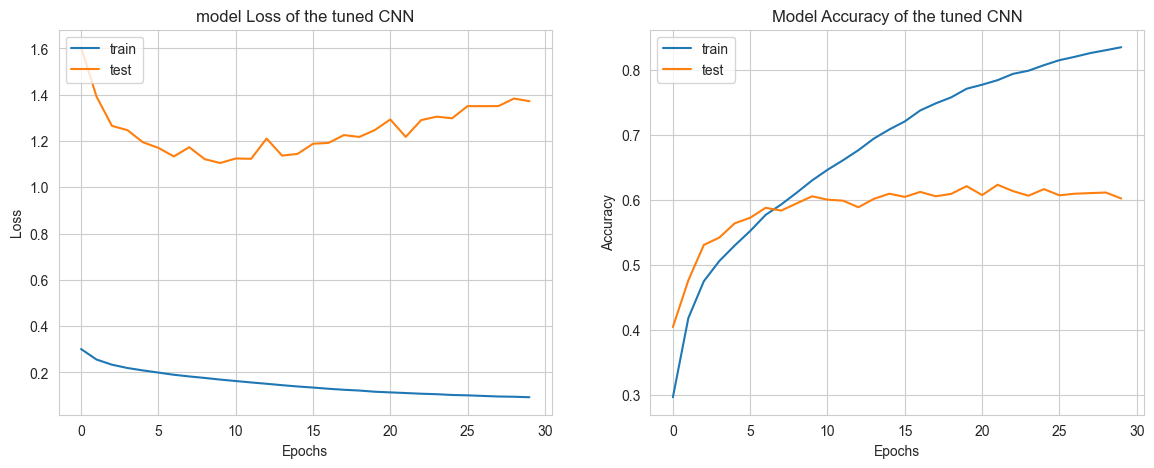

In [37]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 2)
plt.plot(history_3x3.history['accuracy'])
plt.plot(history_3x3.history['val_accuracy'])
plt.title('Model Accuracy of the tuned CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1, 2, 1)
plt.plot(history_3x3.history['loss'])
plt.plot(history_3x3.history['val_loss'])
plt.title('model Loss of the tuned CNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# <h1 style='background:#CCCCCC; border:0; color:black'><center><span style="color: royalblue;"><span style="color: royalblue;">Analyse Results</span></span></center></h1> 

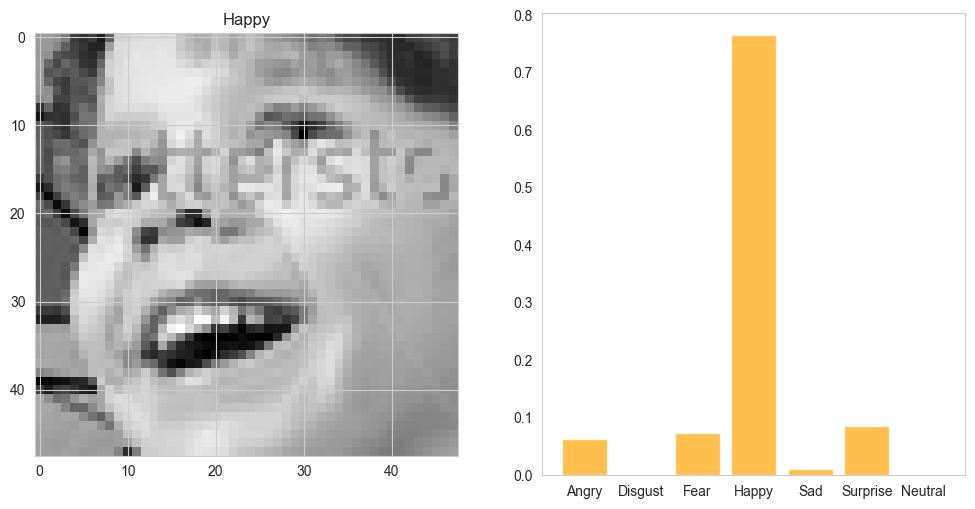

In [38]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels_3x3, 106)

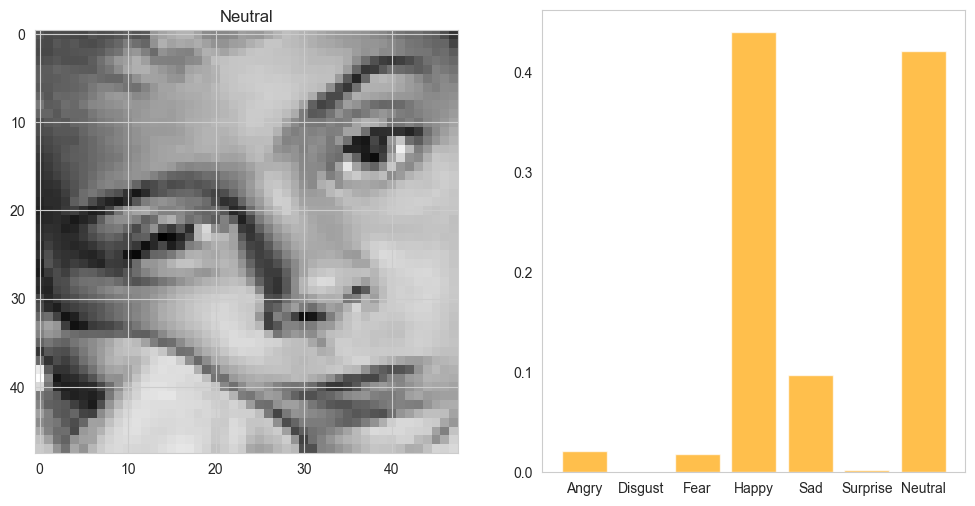

In [39]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels_3x3, 40)

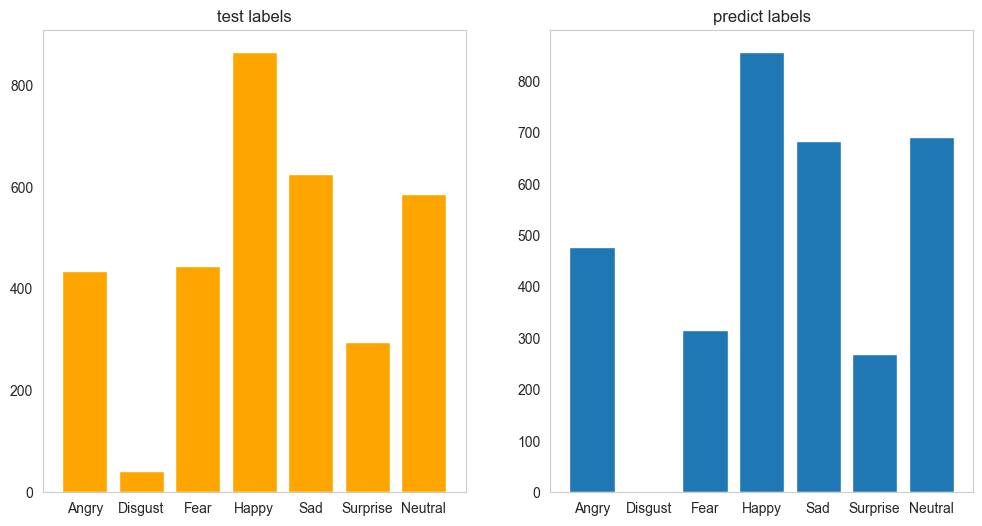

In [40]:
plot_compare_distributions(test_labels, pred_test_labels_3x3, title1='test labels', title2='predict labels')

# <h1 style='background:#CCCCCC; border:0; color:black'><center><span style="color: royalblue;"><span style="color: royalblue;">Analyse Wrong Prediction</span></span></center></h1> 
The accuracy score is about 54% on the test set. So it is obvious to take focus on the wrong predictions. We want to extract details to improve the model.

In [41]:
df_compare = pd.DataFrame()
df_compare['real'] = test_labels.argmax(axis=1)
df_compare['pred'] = pred_test_labels_3x3.argmax(axis=1)
df_compare['wrong'] = np.where(df_compare['real']!=df_compare['pred'], 1, 0)

/var/folders/v5/kvymdr654197fvnj0hz_nqs00000gn/T/ipykernel_92978/1776363748.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


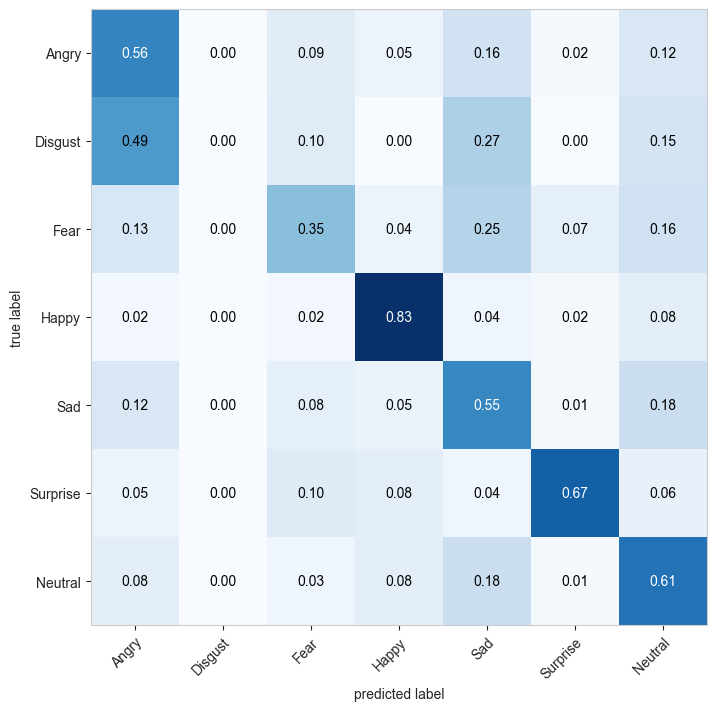

In [42]:
conf_mat = confusion_matrix(test_labels.argmax(axis=1), pred_test_labels_3x3.argmax(axis=1))

fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed=True,
                                show_absolute=False,
                                class_names=emotions.values(),
                                figsize=(8, 8))
fig.show()

In [43]:
pred_class_labels = np.argmax(pred_test_labels_3x3, axis=1)
true_class_labels = np.argmax(test_labels, axis=1)
print(classification_report(true_class_labels, pred_class_labels))

              precision    recall  f1-score   support

           0       0.51      0.56      0.53       435
           1       0.00      0.00      0.00        41
           2       0.49      0.35      0.41       445
           3       0.83      0.83      0.83       865
           4       0.50      0.55      0.53       625
           5       0.74      0.67      0.70       296
           6       0.52      0.61      0.56       586

    accuracy                           0.61      3293
   macro avg       0.51      0.51      0.51      3293
weighted avg       0.61      0.61      0.61      3293



/Users/trminhle/anaconda3/envs/tf_macos/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/trminhle/anaconda3/envs/tf_macos/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/trminhle/anaconda3/envs/tf_macos/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m